<a href="https://colab.research.google.com/github/aguilin1/tda_ai_text_generation/blob/main/tda_ai_text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/aguilin1/tda_ai_text_generation.git

Cloning into 'tda_ai_text_generation'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 113 (delta 58), reused 60 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 5.11 MiB | 4.28 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [2]:
!pip install nltk

In [3]:
# set up Ripser for use (run this just once)
!pip install Ripser

from ripser import ripser, Rips
from persim import plot_diagrams

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.2 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=030d02d1defee6cd22fad96b6f9df196524a7e8c610e0420bcf7a05a3a559e30
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [14]:
# Functions ---
# cosSimDistanceMatrix: creates cosine similarity distance matrix
# vrFiltration: takes a distance matrix and computes Vietoris-Rips filtration

from sklearn.metrics.pairwise import cosine_similarity
import itertools

def angular_distance(embeddings, index_1, index_2):
  cos_sim = cosine_similarity(embeddings[index_1].reshape(1, -1),\
                              embeddings[index_2].reshape(1, -1))[0][0]

  dist = 2 * np.arccos(cos_sim) / np.pi
  return dist

# input a single array of embeddings
def angular_distance_matrix(embeddings):
  # get # of data points in each sample
  n_dpts = embeddings.shape[0]
  # preallocate distance matrix
  angular_distances = np.zeros((n_dpts, n_dpts))
  # Label each data point in order starting at 0, 1, 2, ...
  # Distance between data point i and data point j is in (i,j) entry of matrix
  # Matrix will be upper triangular
  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    dist = angular_distance(embeddings, pair1_i, pair2_i)
    angular_distances[pair1_i][pair2_i] = dist
    angular_distances[pair2_i][pair1_i] = dist
  return angular_distances


def mixed_distance_matrix(bow_embeddings, bert_embeddings, alpha):
  # This should align with the tokens (number of sentences), so match between types
  n_dpts = bert_embeddings.shape[0]

  cosSimDistances = np.zeros((n_dpts, n_dpts))

  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    distance_bow = angular_distance(bow_embeddings, pair1_i, pair2_i)
    distance_bert = angular_distance(bert_embeddings, pair1_i, pair2_i)
    dist = alpha * distance_bow + (1 - alpha) * distance_bert

    cosSimDistances[pair1_i][pair2_i] = dist
    cosSimDistances[pair2_i][pair1_i] = dist
  return cosSimDistances

# input a symmetric distance matrix and this function will return birth and
# death homology data for the V-R complex
def ripserFiltration(distanceMat, maxDim=2):
  # Here's one way to use Ripser
  # examples and instructions are here:
  # https://ripser.scikit-tda.org/en/latest/notebooks/Basic%20Usage.html
  # https://docs.scikit-tda.org/en/latest/notebooks/scikit-tda%20Tutorial.html#1.1.3.-Input-option:-Distance-matrix

  # This version uses the distance matrix input, which is what we want
  birthDeathPairs = ripser(distanceMat, distance_matrix=True, maxdim=maxDim)['dgms']

  # diagrams is a vector of vectors where each element of each
  # vector is [birth epoch, death epoch] and the vectors are in increasing order
  # of homology (H0, H1, H2, etc.).
  return birthDeathPairs

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


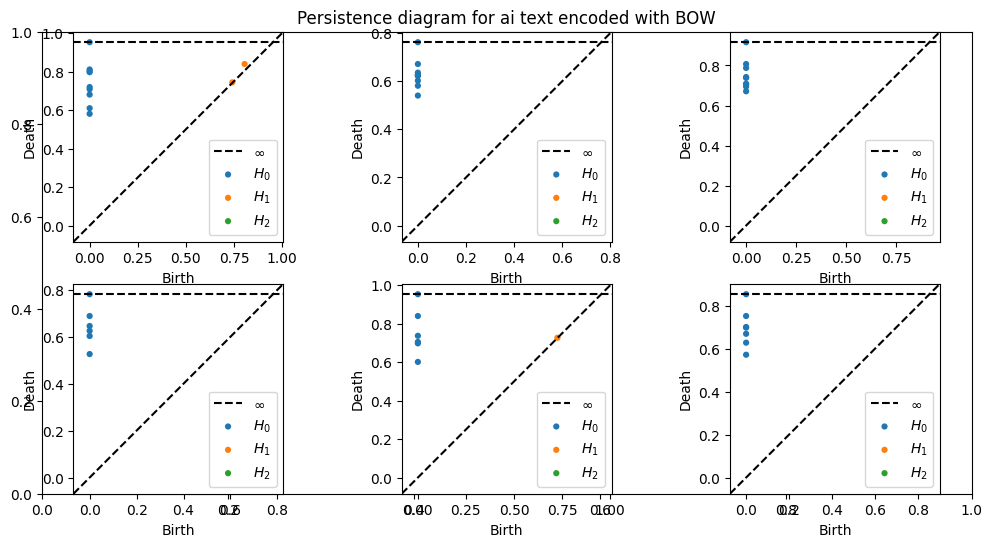

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


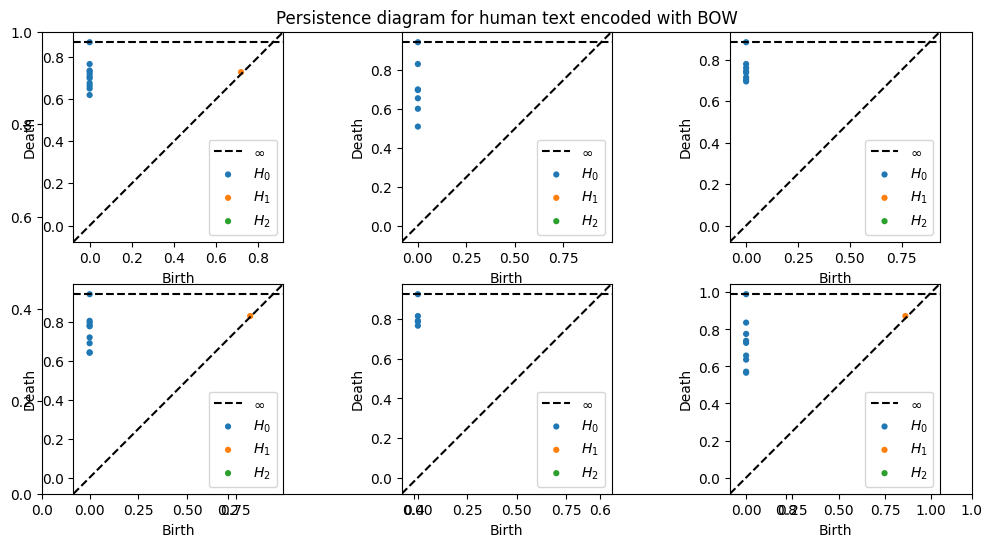

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


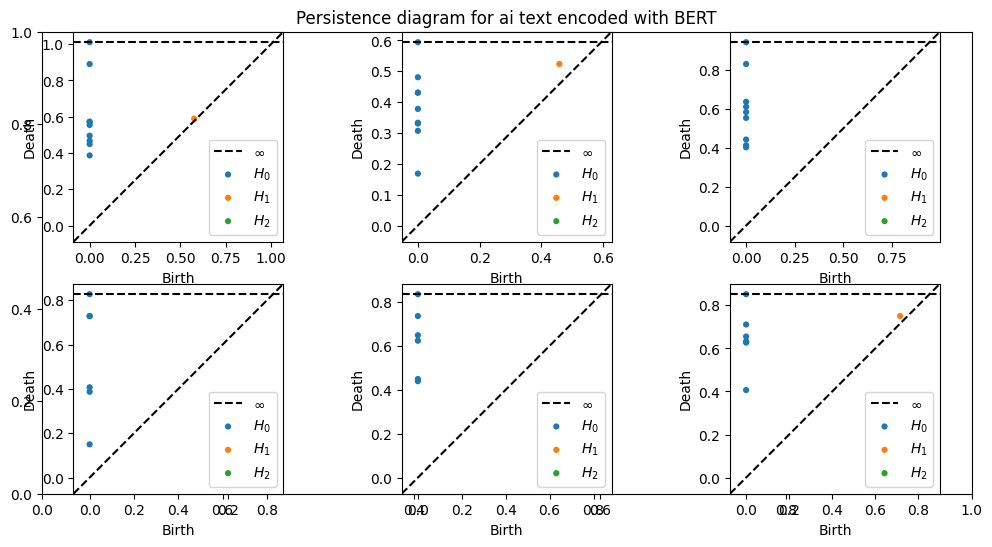

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


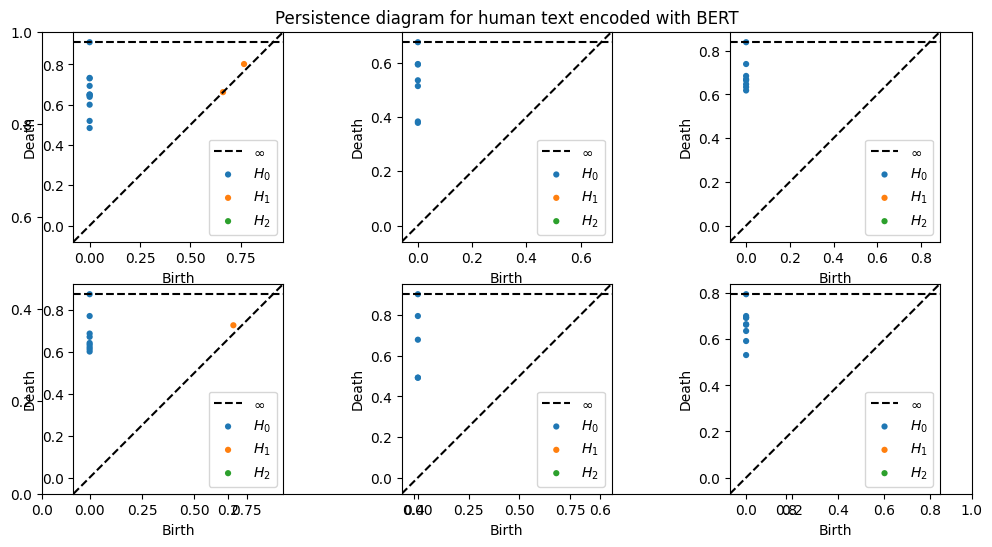

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


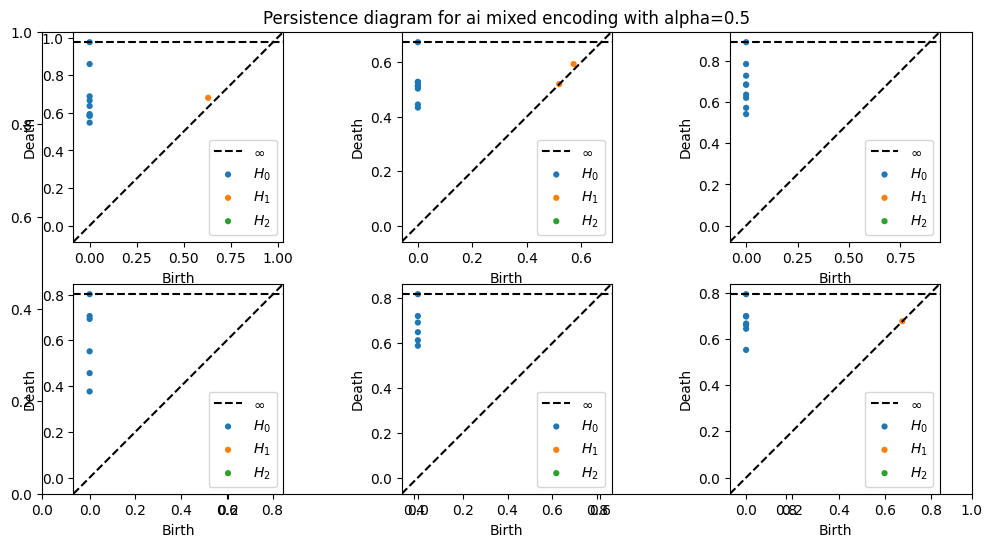

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


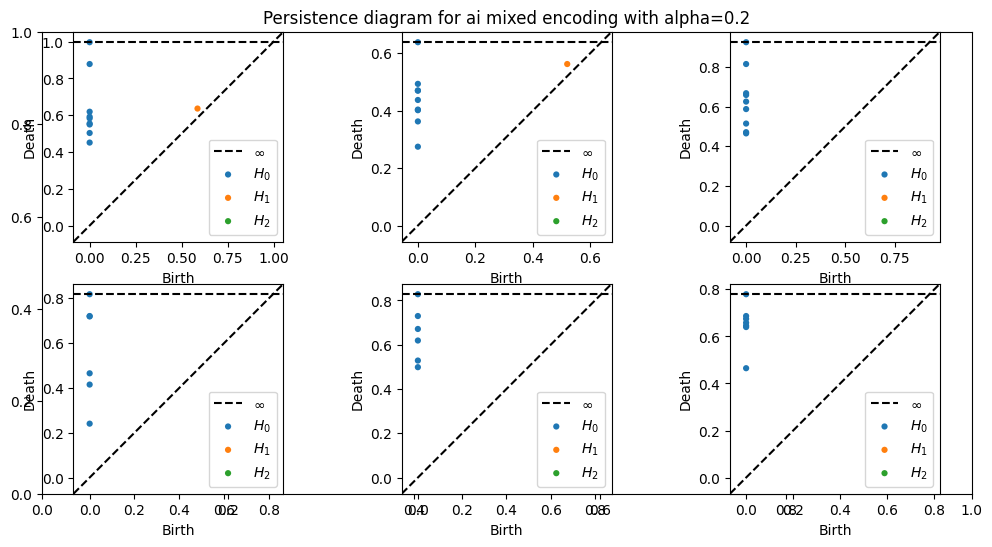

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


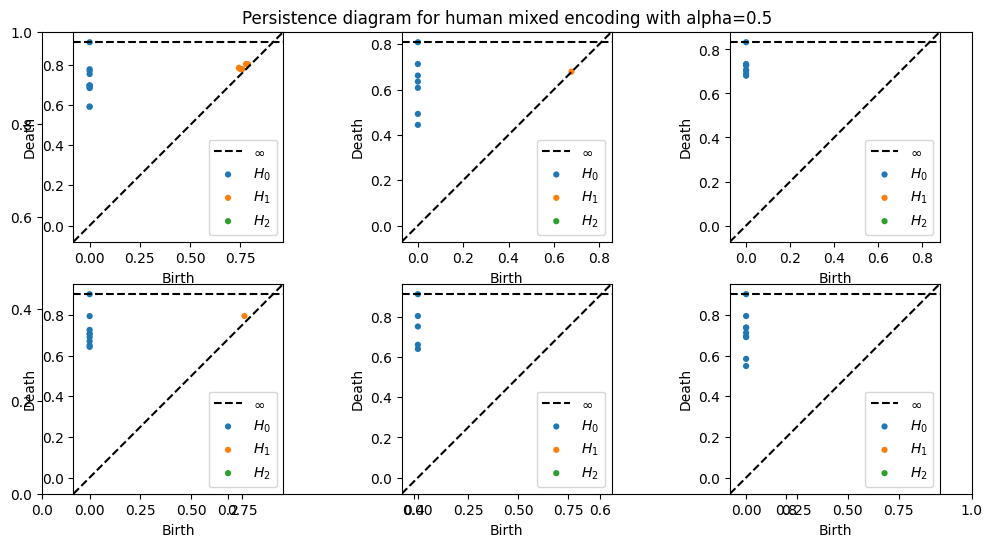

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


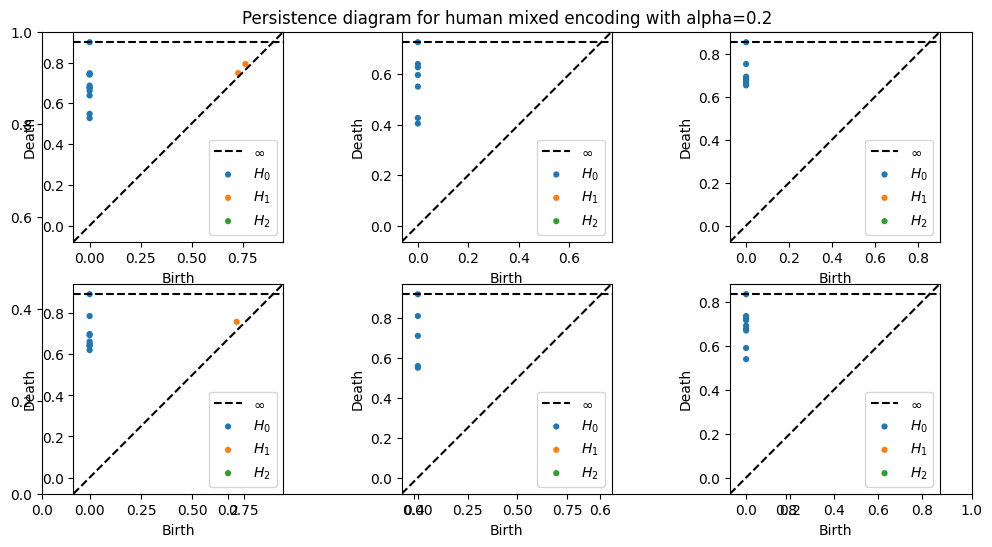

In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

def load_cached_embeddings(abstract_type, embedding_type):
  DATA_FILE_BASE = '/content/tda_ai_text_generation/data/{}_encodings_{}-{}.pkl'

  bert_data = DATA_FILE_BASE.format('sentence-bert', abstract_type, 1)
  bow_data = DATA_FILE_BASE.format('bow', abstract_type, 0)


  if embedding_type == 'bert':
    with open(bert_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  elif embedding_type == 'bow':
    with open(bow_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  return batch_sentences, batch_embeddings


def run_evaluation(abstract_type, embedding_type):
  _, batch_embeddings = load_cached_embeddings(abstract_type, embedding_type)

  rips = Rips()
  bert_diagrams = []
  plt.figure(figsize=(12,6))
  plt.title("Persistence diagram for {} text encoded with {}".format(abstract_type, embedding_type.upper()))
  subplot = 1
  for i, embeddings in enumerate(batch_embeddings[0:6]):
    distances = angular_distance_matrix(embeddings)
    diagram = ripserFiltration(distances)
    bert_diagrams.append(diagram)

    plt.subplot(2,3,subplot)
    subplot += 1
    rips.plot(diagram, show=False)


  plt.show()


def run_mixed_encoding_evaluation(abstract_type, alpha, n):
  _, batch_bow_embeddings = load_cached_embeddings(abstract_type, 'bow')
  _, batch_bert_embeddings = load_cached_embeddings(abstract_type, 'bert')
  if alpha < 0.0 and alpha > 1.0:
    raise ValueError("alpha must be between 0 and 1")

  rips = Rips()
  bert_diagrams = []
  plt.figure(figsize=(12,6))
  plt.title("Persistence diagram for {} mixed encoding with alpha={}".format(abstract_type, alpha))
  subplot = 1
  for i in range(n):
    distances = mixed_distance_matrix(batch_bow_embeddings[i], batch_bert_embeddings[i], alpha)
    diagram = ripserFiltration(distances)
    bert_diagrams.append(diagram)

    plt.subplot(2,3,subplot)
    subplot += 1
    rips.plot(diagram, show=False)


  plt.show()

run_evaluation('ai', 'bow')
run_evaluation('human', 'bow')

run_evaluation('ai', 'bert')
run_evaluation('human', 'bert')

run_mixed_encoding_evaluation('ai', 0.5, 6)
run_mixed_encoding_evaluation('ai', 0.2, 6)
run_mixed_encoding_evaluation('human', 0.5, 6)
run_mixed_encoding_evaluation('human', 0.2, 6)

In [ ]:
## To wrap the array outputs for readability
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

[ 0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6  6  7  7  7  7  8  9 10
 11 12 12 13 13 13 13 13 14 14 15 15 15 15 16 16 16 16 17 17 17 17 18 18
 19 19 19 19 19 19 19 20 20 20 20 21 21 21 21 21 21 21 21 21 21 22 22 22
 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 29 30 30 31 31
 31 31 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33 33 34 34 34 34
 34 34 34 34 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[-1  5  8  2 10  3 29  1  9 -1 -1 -1  4 -1 -1  6 -1  7 -1  7 -1 -1 -1 -1
 13 12 -1 13 -1 -1 13 -1 14 -1 15 -1 15 -1 16 -1 16 -1 17 -1 17 -1 18 -1
 19 -1 19 19 -1 -1 -1 20 -1 20 -1 21 -1 21 21 21 -1 -1 -1 -1 -1 22 -1 22
 22 

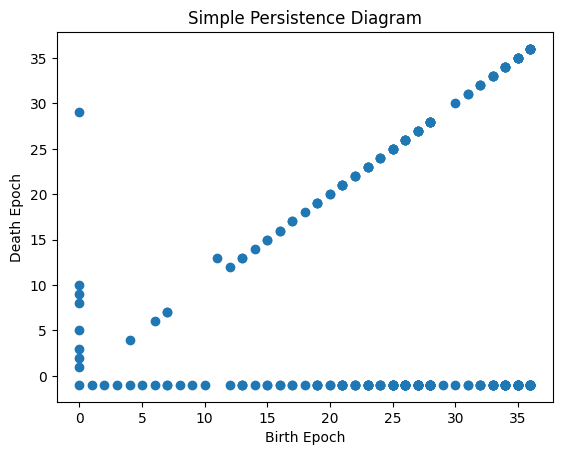

In [ ]:
# test plot of the birth and death data.
import matplotlib.pyplot as plt
print(birthEpoch)
print(deathEpoch)

# Create scatter plot
plt.scatter(birthEpoch, deathEpoch)

# Add title and labels
plt.title('Simple Persistence Diagram')
plt.xlabel('Birth Epoch')
plt.ylabel('Death Epoch')

# Show plot
plt.show()

In [ ]:
# Gather 3 sets: human cases, AI cases, and test ("unknown") cases

# Determine a representative persistence diagram for human cases and AI cases? HOW?

# Compare each of the test cases against the representative diagrams, classify,
# and determine whether classification was successful or not

# suggest using
# https://persim.scikit-tda.org/en/latest/notebooks/distances.html

# Example
# if A and B are two Ripser persistence diagrams to be compared
#distance = persim.bottleneck(A, B, matching=False)
# and then just see whether the test case distance from human diagram is smaller
# or larger than distance from AI diagram. Classify based on smaller distance